# Проект персонализированных приложений

## Постановка задачи

Задача: построить модель предсказания покуательской активности, чтобы удержать активность постоянных клиентов путем персонализированных предложений.

Подход к решению задачи:
1. Промаркировать уровень активности постоянных покупателей исходя из уровней: "снизилась", "прежний уровень".
2. Собрать данные по клиентам по группам:
* признаки коммуникации сотрудников компании с клиентом;
* признаки продуктового поведения покупателя;
* признаки покупательского поведения клиента;
* признаки поведения покупателя на сайте
3. Построить модель предсказания вероятности снижения покупательской активности в следующие три месяца
4. Провести исследование с учетом данных о прибыльности клиента за три месяца;
5. Используя данные модели и данные о прибыльности выделить сегменты покупателей и разработать для них персонализированные предложения.

# Описание данных
Данные для работы находятся в нескольких датафреймх. Нажмите на название файла, чтобы его скачать.
<br> Файл market_file.csv
<br> датафрейм, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
<br>Файл market_money.csv
<br>датафрейм с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.
<br> Файл market_time.csv
<br> датафрейм с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.
<br> Файл money.csv
<br> датафрейм с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

In [1]:
# установка требуемых библиотек
!pip install phik -q
!pip install shap -q
!pip install scikit-learn -q

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
                             r2_score, accuracy_score,
                             confusion_matrix,
                             roc_auc_score
                            )
from sklearn.preprocessing import (
                                    StandardScaler,
                                    MinMaxScaler,
                                    OneHotEncoder,
                                    OrdinalEncoder,
                                    LabelEncoder
                                   )
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import phik
import shap
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams['font.size'] = 18.0
sns.set_context(
                'notebook',
                rc={
                    'font.size': 15,
                    'axes.titlesize': 10,
                    'xtick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    'legend.fontsize': 'small',
                    'legend.title_fontsize': 10
                }
            )
RANDOM_STATE = 50

In [3]:
import sklearn
sklearn.__version__

'1.3.0'

# 1. Загрузка данных

In [4]:
try:
	market_file_df = pd.read_csv('/datasets/market_file.csv', sep=',')
	market_money_df = pd.read_csv('/datasets/market_money.csv', sep=',')
	market_time_df = pd.read_csv('/datasets/market_time.csv', sep=',')
	money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')
except:
	market_file_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',')
	market_money_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',')
	market_time_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',')
	money_df = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal = ',')



Проверяю как зачитались данные:

In [5]:
market_file_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


# 2. Предобработка данных

## Датафрейм market_file

Общая информация о данных:

In [9]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Типы данных в порядка, количество заполенных строк по таблице совпадает.

Проверка пропусков:

In [10]:
market_file_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Пропусков нет. Проверяю на явные дубликаты:

In [11]:
market_file_df.duplicated().sum()

0

## Датафрейм market_money

Вывод общей информации о данных:

In [12]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


С типами данных все в порядке.

Убеждаюсь, что пропусков нет:

In [13]:
market_money_df.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

Проверка на явные дубликаты:

In [14]:
market_money_df.duplicated().sum()

0

Явных дубликатов не обнаружено.

## Датафрейм market_time

Вывожу общую информацию по таблице:

In [15]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Типы данных соответствуют, пропусков быть не должно. Убеждаюсь в этом:

In [16]:
market_time_df.isna().sum()

id        0
Период    0
минут     0
dtype: int64

Пропусков нет. Проверяю на явные дубликаты:

In [17]:
market_time_df.duplicated().sum()

0

## Датафрейм money

Вывожу общую информацию по таблице:

In [18]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Типы данных соответствуют, пропусков быть не должно. Убеждаюсь в этом:

In [19]:
money_df.isna().sum()

id         0
Прибыль    0
dtype: int64

Проверяю на явные дубликаты:

In [20]:
money_df.duplicated().sum()

0

Явных дубликатов не обнаружено.

# 3. Исследовательский анализ данных

## Датафрейм market_file

Проверяю, нет ли дубликатов среди покупателей:

In [21]:
len(market_file_df['id'].unique())

1300

График с нумирацией id покупателей:

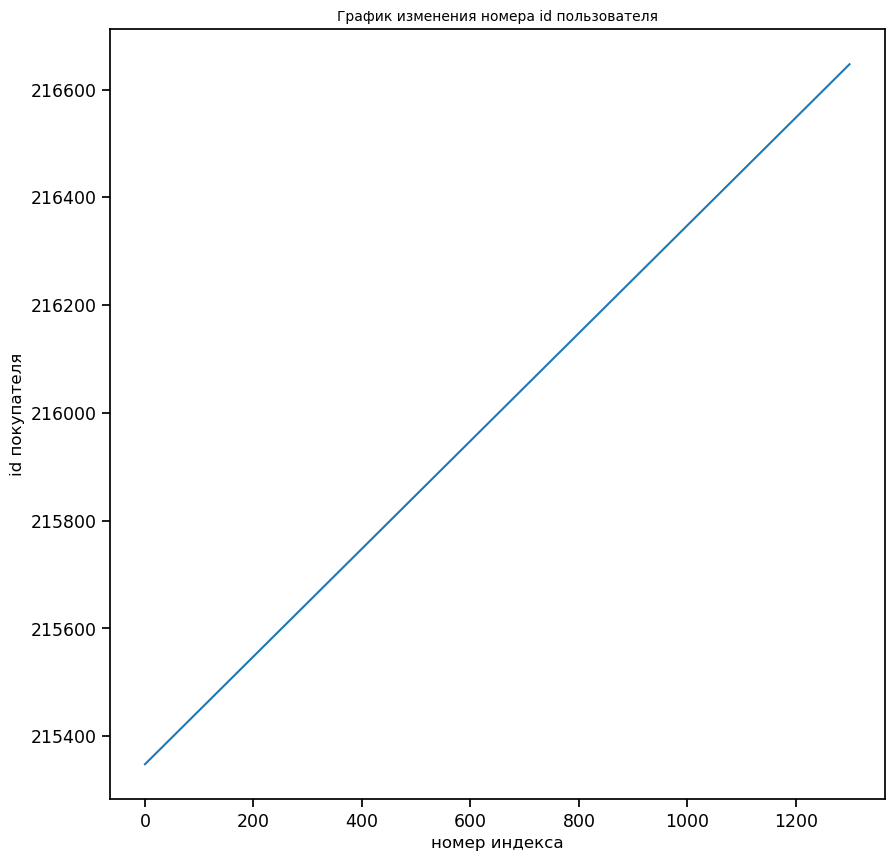

In [22]:
market_file_df['id'].plot(
                            xlabel = 'номер индекса',
                            ylabel = 'id покупателя',
                            title='График изменения номера id пользователя'
                         );

Все id идут последовательно. То есть отсортированы в порядке возрастания без скачков.

Вывожу гистограммы количественных признаков:

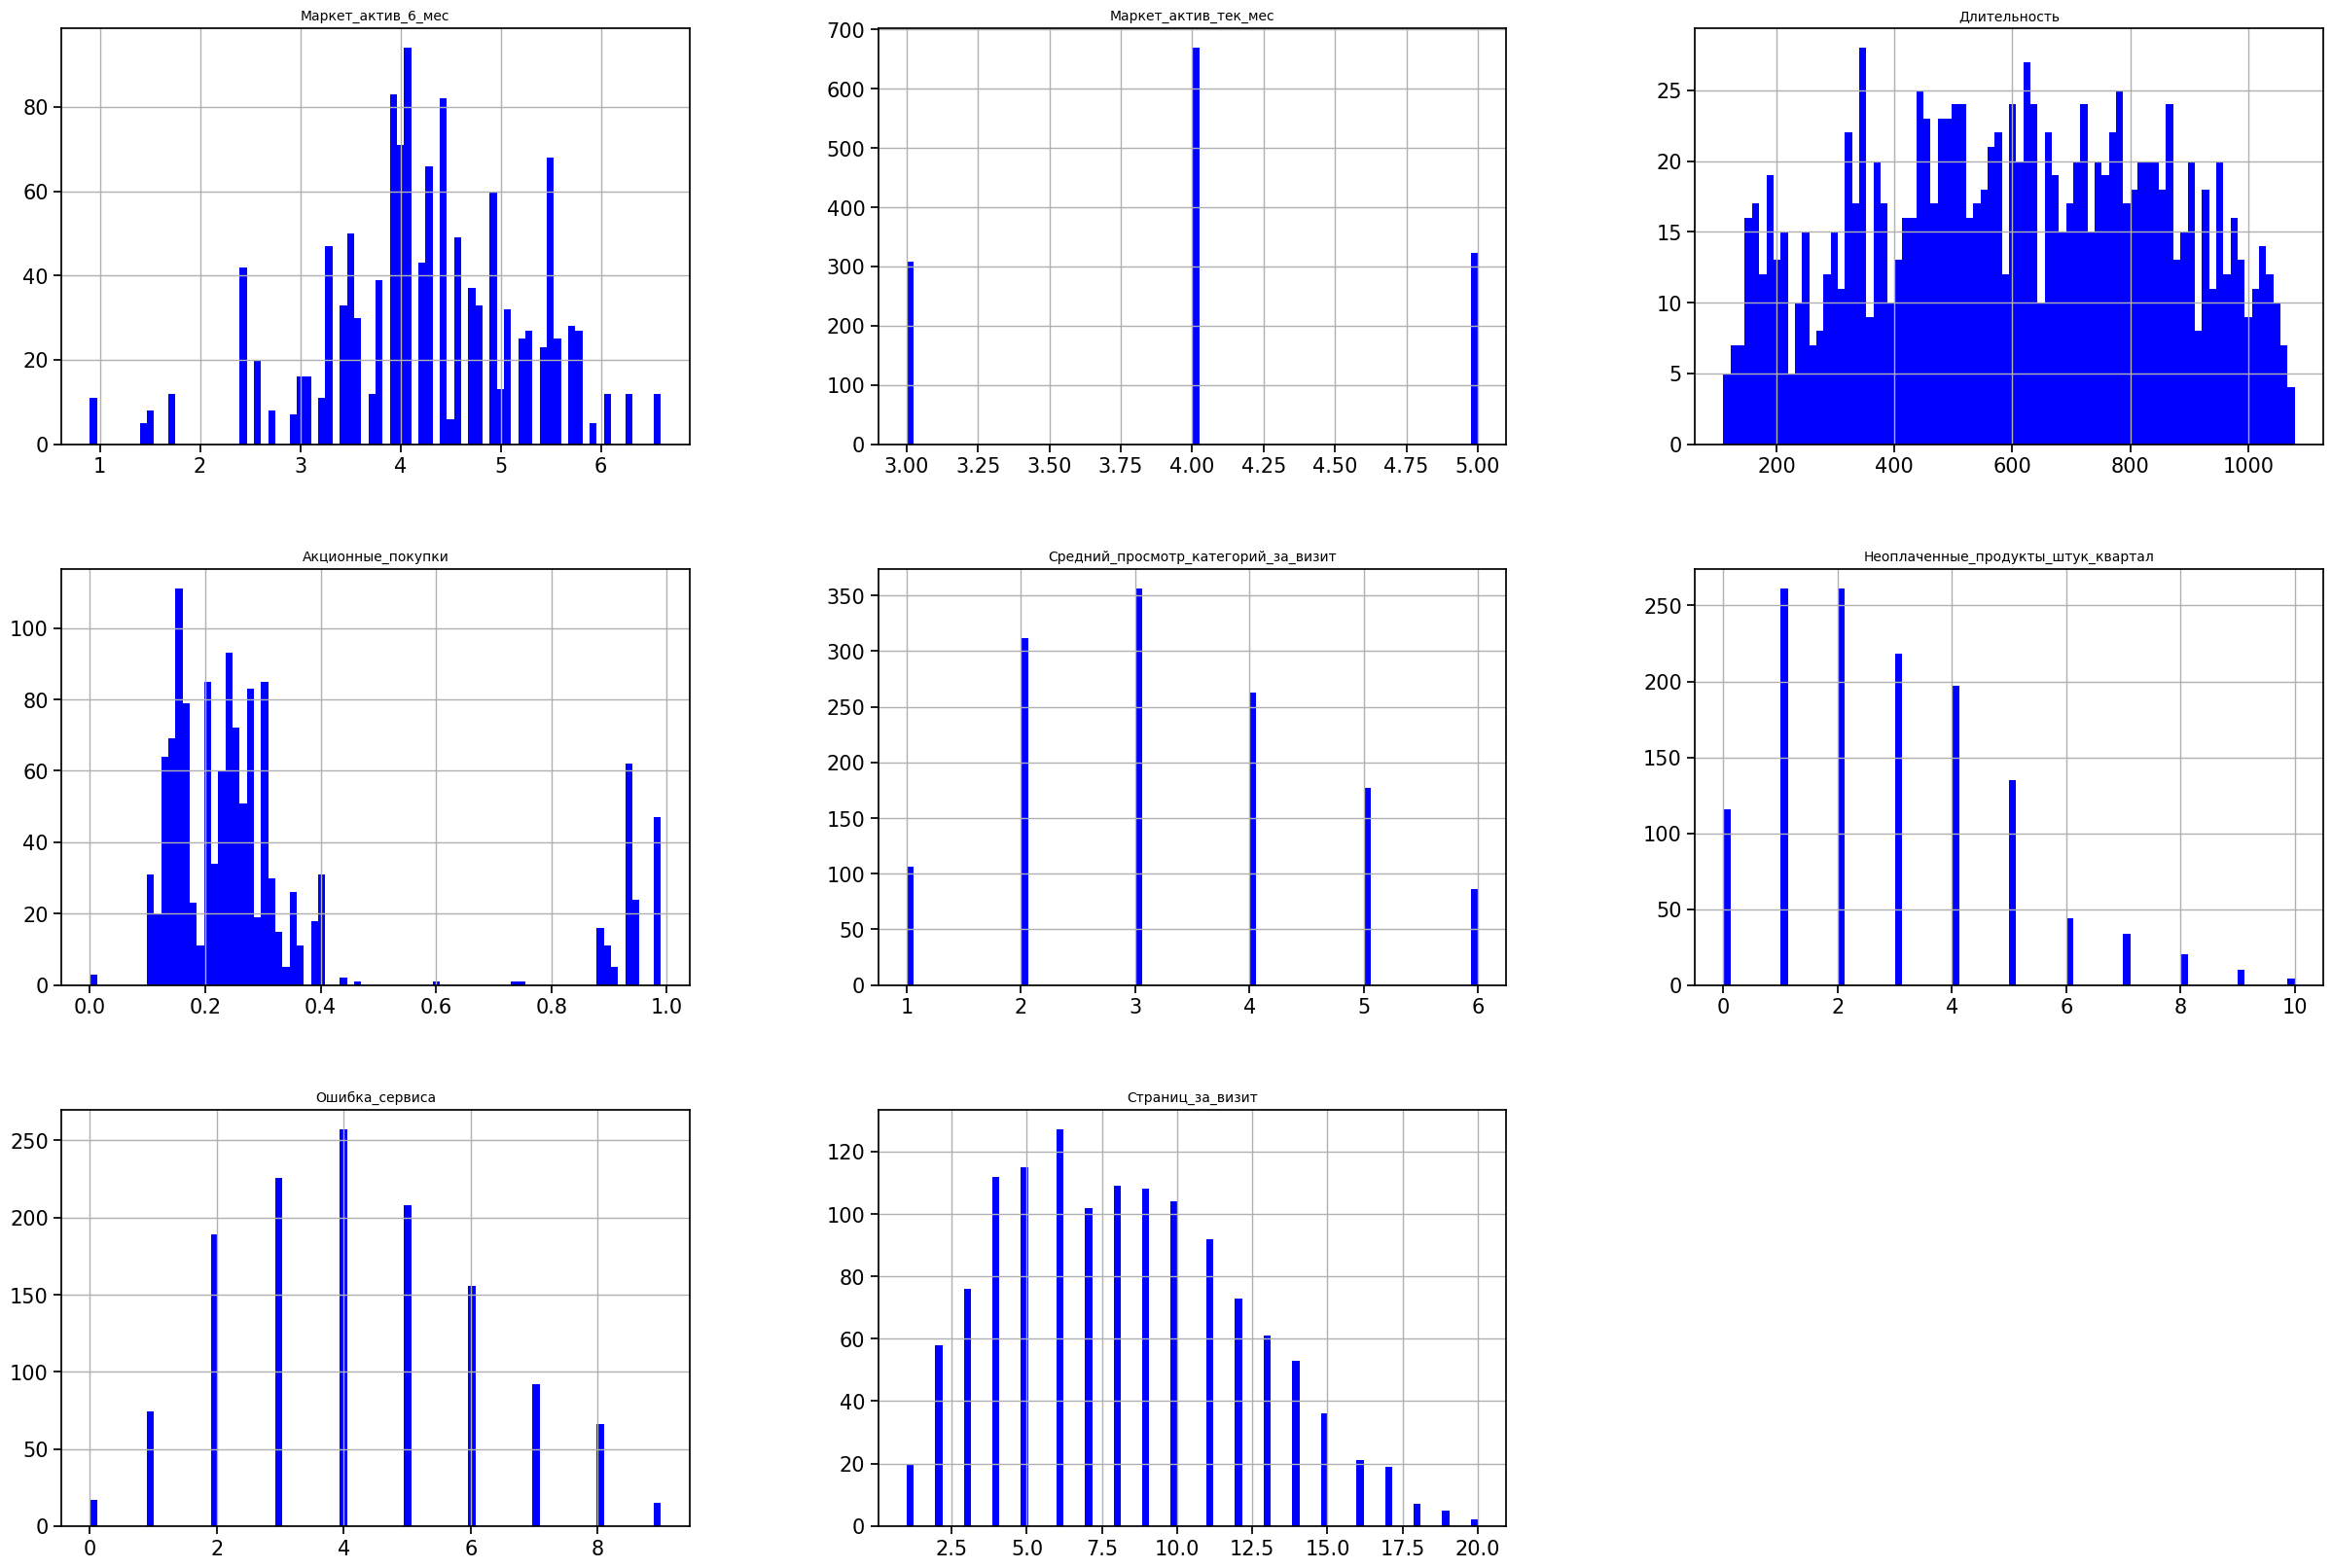

In [24]:
plt.rcParams['font.size'] = 18.0
market_file_df.drop('id', axis=1).hist(bins=80, figsize=(30, 20), color='b');

Признак "Акционные_покупки" имеет подозрительно низкие значения в диапазоне от 0,4 до 0,9. Возможно интервал от 0,9 до 1 содержит выбросы.
<br> "Ошибка_сервиса" имеет биномиальное расперделение, близкое к симметричному.
<br>

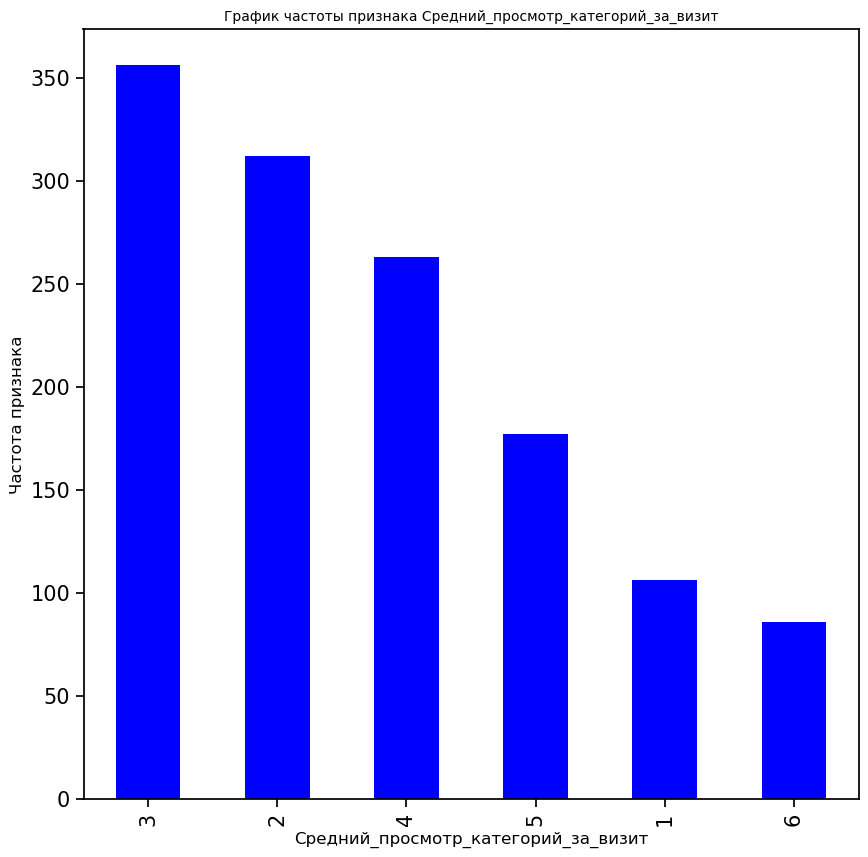

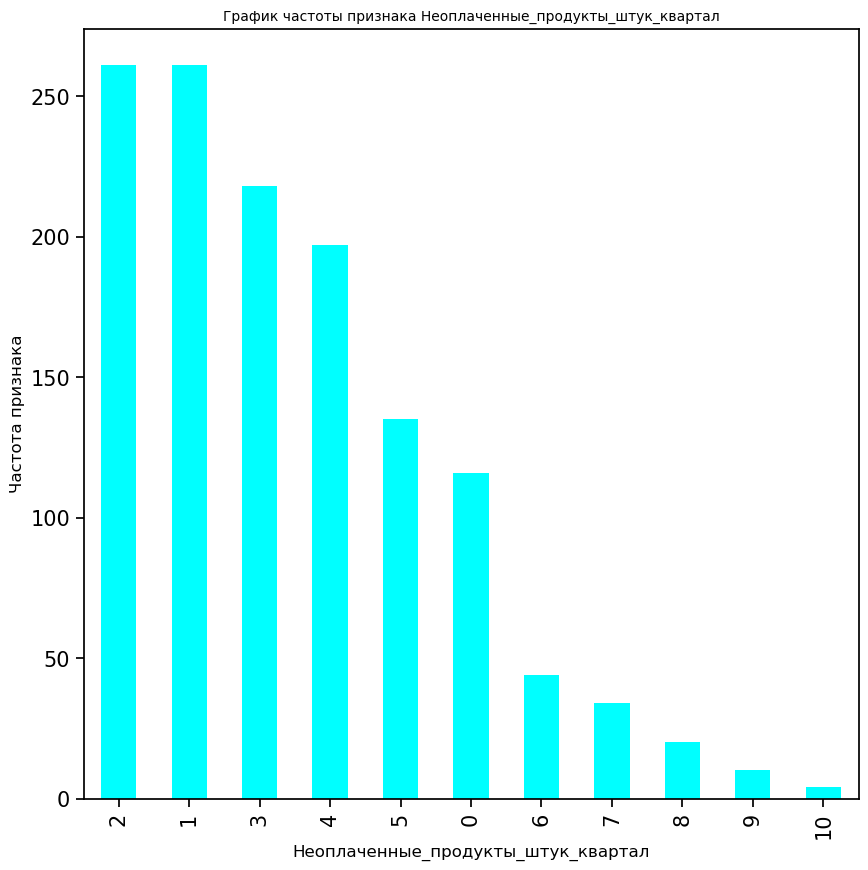

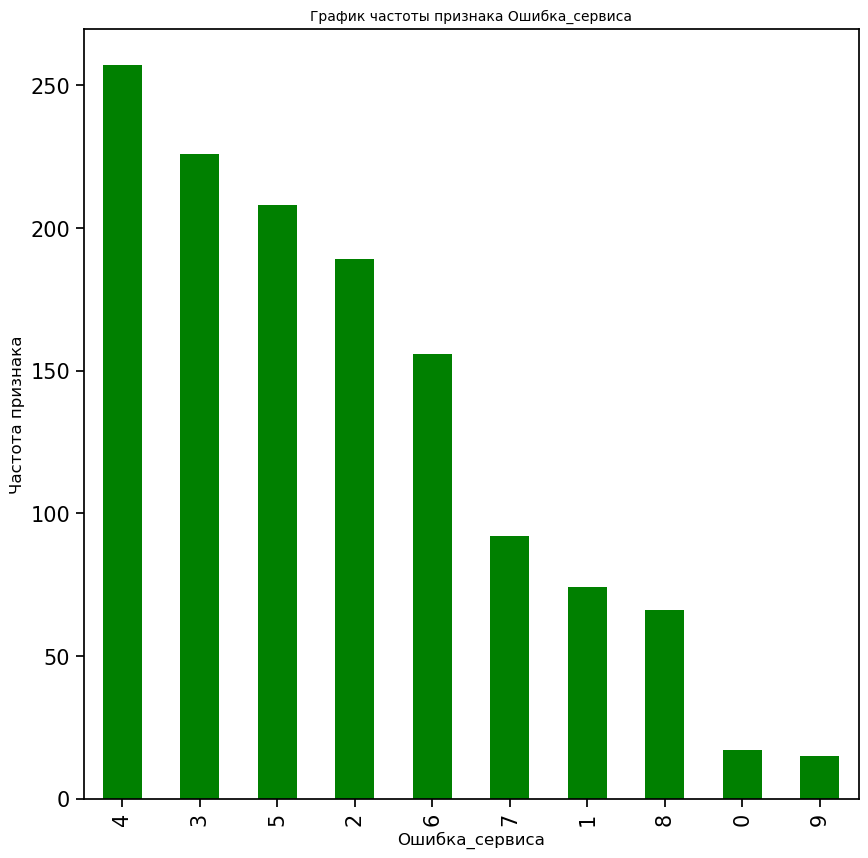

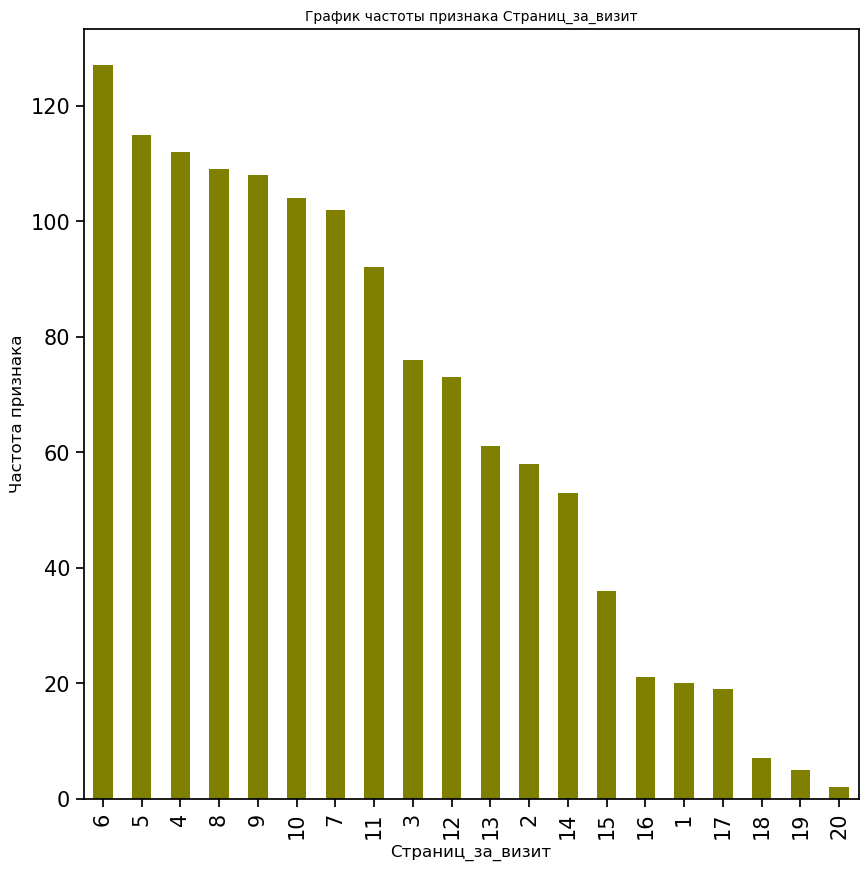

In [25]:
disc_col_list = [
                     'Средний_просмотр_категорий_за_визит', 
                     'Неоплаченные_продукты_штук_квартал', 
                     'Ошибка_сервиса', 
                     'Страниц_за_визит'
                ]
color = ['blue', 'cyan', 'green', 'olive']
for i in range(len(disc_col_list)):
    plt_name = 'График частоты признака ' + disc_col_list[i]
    data_bar = market_file_df[disc_col_list[i]].value_counts()
    data_bar.plot(
                kind='bar',
                xlabel = disc_col_list[i],
                ylabel = 'Частота признака',
                title=plt_name,
                color = color[i]
              );
    plt.show()
    print()

Итак, по сотлбчатым диаграммам видно:
* покупатели часто просматривают 3 категрии, реже 1 или 6;
* неоплаченных продуктов больше всего в диапазоне от 1 до 4х. 
* число сбоев которые коснулись покупателя во время посещения сайта (признак "Ошибка_сервиса") от 3-х до 5 составляет более 670 при том что у нас 1300 покупателей. Это много, сбои отталкивают покупателей.
* лидерующим явлеятся просмотр 6 стрнаиц за визит

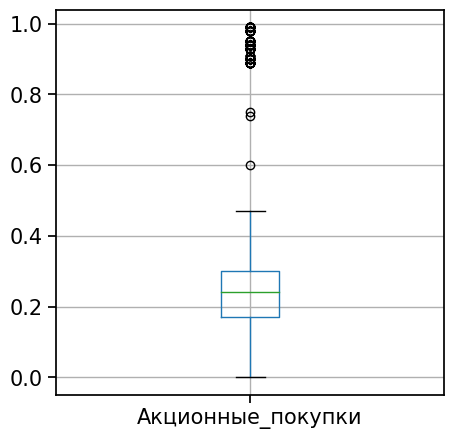

In [26]:
market_file_df.boxplot(['Акционные_покупки'], figsize=(5, 5));

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично! Боксплот рядом с гистограммой - это отлично! Гистограмма будет показывать нам распределение количественного признака, а боксплот даст информацию о выбросах и основных статистиках (квартилях) признака.
</div>

Число покупателей, у которых среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев более 80% составляет:

In [27]:
len(market_file_df.query('Акционные_покупки > 0.8'))

In [28]:
print(f"Процент таких покупателей: {len(market_file_df.query('Акционные_покупки > 0.8'))/len(market_file_df):.1%}")

Таким образом 12,7 % покупателей приобретали в основном акционные товары.

Вывожу пироговые диаграммы категориальных признаков:

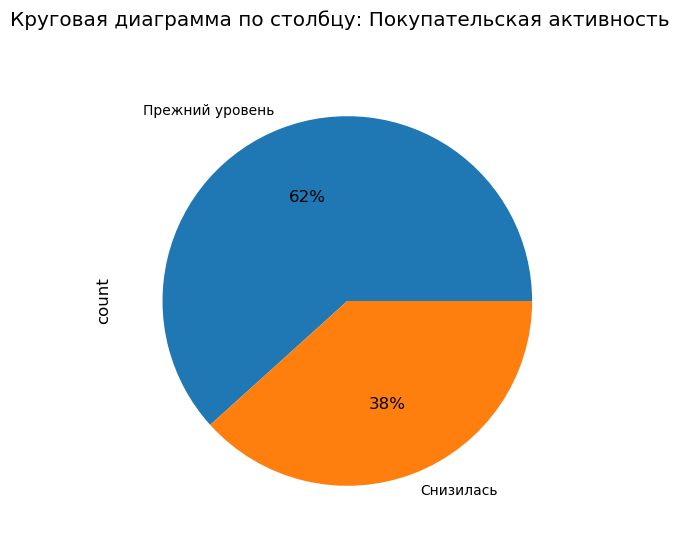

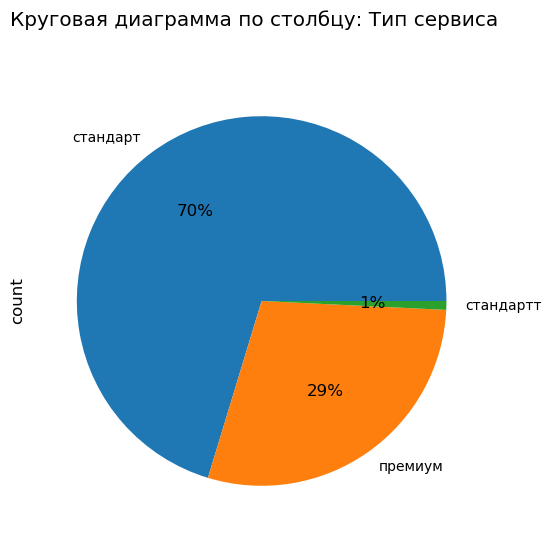

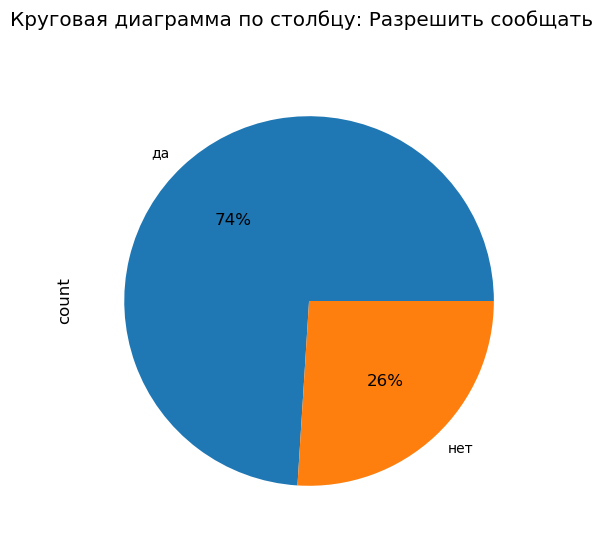

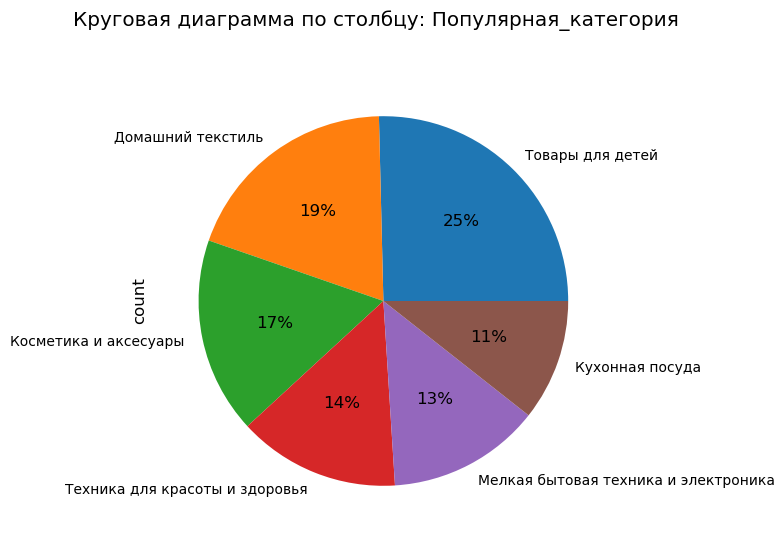

In [29]:
col_list_str = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
for i in range(len(col_list_str)):
    plt.rcParams['figure.figsize'] = [6, 6]
    plt.rcParams['font.size'] = 12.0
    market_file_df[col_list_str[i]].value_counts().plot(kind='pie', autopct='%.0f%%');
    title = 'Круговая диаграмма по столбцу: ' + col_list_str[i]
    plt.suptitle(title)
    plt.show()
    print() # для отделения графиков

В столбце "Тип сервиса" обнаружена опечатка в названии катеории "стандарт". Её надо сиправить. Также видно, что 29% - покупатели с премиальным сервисом.
<br> Видно, что у 38% покупателей сниизлась активность. Это по заданию наш целевой признак. Кроме того, поскольку есть дисбаланс класса покупательской активности нужно будет стратифицировать выборку.
<br> 26% покупателей не разрешила сообщать информацию о товаре.
<br> Самой популярной категореий товаров были "Товары для детей" - 25%, а наименее популярной была "Кухонная посуда", но она составила 11% что тоже не мало.

Удаляю опечатку в столбце "Тип_сервиса" и проверяю:

In [30]:
market_file_df['Тип сервиса'] = market_file_df['Тип сервиса'].replace('стандартт','стандарт')
market_file_df['Тип сервиса'].unique()

## Датафрейм market_money

Проверяю, что число уникальных id покупателя совпадает с числом id market_file

In [31]:
j = 0
for elm in market_money_df['id'].unique():
    if elm not in market_file_df['id'].unique():
        j = j + 1 #счетчик лишних id
        print(f'{elm} отстуствует в таблице market_file_df')
if j == 0:
    print('все id совпадают')

Проверяю уникальные значения столбца "Период" на наличие опечаток. Ожидаю увидеть только 3 категории.

In [32]:
market_money_df['Период'].unique()

Все в порядке.

Вывожу описание данных по выручке:

In [33]:
market_money_df['Выручка'].describe()

Максимальное значение в 20 раз выше среднего. Но в целом явно огрмных данных не видно. Выведу покупателей с нулевой выручкой.

In [34]:
market_money_df.query('Выручка == 0')

## Датафрейм market_time_df

Проверяю соответствие уникальных id покупателя датафрейму market_file:

In [35]:
j = 0
for elm in market_time_df['id'].unique():
    if elm not in market_file_df['id'].unique():
        j = j + 1 #счетчик лишних id
        print(f'{elm} отстуствует в таблице market_file_df')
if j == 0:
    print('все id совпадают')

Вывожу уникальные значения столбца "Период":

In [36]:
market_time_df['Период'].unique()

Устаняю замеченную опечатку и проверяю:

In [37]:
market_time_df['Период'] = market_time_df['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time_df['Период'].unique()

Вывожу описание данных столбца "минут":

In [38]:
market_time_df['минут'].describe()

Значения минут выглядят резонно

## Датафрейм money

Проверяю соответствие уникальных id покупателя датафрейму market_file:

In [39]:
j = 0
for elm in money_df['id'].unique():
    if elm not in market_file_df['id'].unique():
        j = j + 1 #счетчик лишних id
        print(f'{elm} отстуствует в таблице market_file_df')
if j == 0:
    print('все id совпадают')

Вывожу описание данных о прибыли покупателей:

In [40]:
money_df['Прибыль'].describe()

Значение прибыли выглядит маленьким по сравнению с данными о выручке. Так ни один бизнес не работает. В реальной работе размер прибыли надо уточнить у заказчика.
<br> Суммарная выручка за три месяца от первого покупателя составила:

In [41]:
market_money_df.loc[0:2,'Выручка'].sum()

Среднемесячная пирбыль от первого покупателя:

In [42]:
money_df.loc[0, 'Прибыль']

Прибыль не может больше выручки, но и такой маленькой не бывает. Если увеличить её в 1000 раз, то значения будут логичны.

In [43]:
money_df['Прибыль'] = money_df['Прибыль'] * 1000
money_df.head()

## Отбор клиентов с покупательской активностью не менее трёх месяцев

Отбор по выручке за три месяца из датафрейма market_money и занесение их в список:

In [44]:
pt_money = market_money_df.pivot_table(
    index='id',
    columns='Период',
    values='Выручка',
    aggfunc=lambda x: x>0
    )
#для фильтрации активных каждый месяц покупателей добавляю столбец
pt_money['cond_meet'] = pt_money.sum(axis=1)
# формирую список клиентов с требуемой покупательской активностью
active_cust_list = list(pt_money[pt_money['cond_meet'] == 3].index)
print('Отобранных покупателей:', len(active_cust_list))

## Вывод по исследованиям данных

По результатам анадиза данных были выявлены и устранены опечатки, исправлены значения прибыли. Кроме того убедился, что во всех файлах одинаковые id покупателей, значит можно объединять таблицы по id.
<br> Отобраны покупатели, которые что-либо покупали каждый месяц за трехмесячный период. Таких оказалось 1297 из 1300, то есть почти все.

# 4. Объединение таблиц в один датафрейм

In [45]:
pt_money = market_money_df.pivot_table(
    index='id',
    columns='Период',
    values='Выручка'
    )
pt_money = pt_money.reset_index(drop=True)
pt_money.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']

In [46]:
pt_time = market_time_df.pivot_table(
    index='id',
    columns='Период',
    values='минут'
    )
pt_time = pt_time.reset_index(drop=True)
pt_time.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']

In [47]:
tot_df = market_file_df.join([pt_money, pt_time])
tot_df.head()

Таким образом данные объединены и можно проводить корреляционный анализ.

# 5. Корреляционный анализ

Формирую список признаков в количественной шкале

In [48]:
cat_col = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
num_col = list(tot_df.columns)
for elm in cat_col:
    num_col.remove(elm)
num_col.remove('id')
num_col

In [49]:
sns.set_theme(rc={'figure.figsize':(11, 8)})

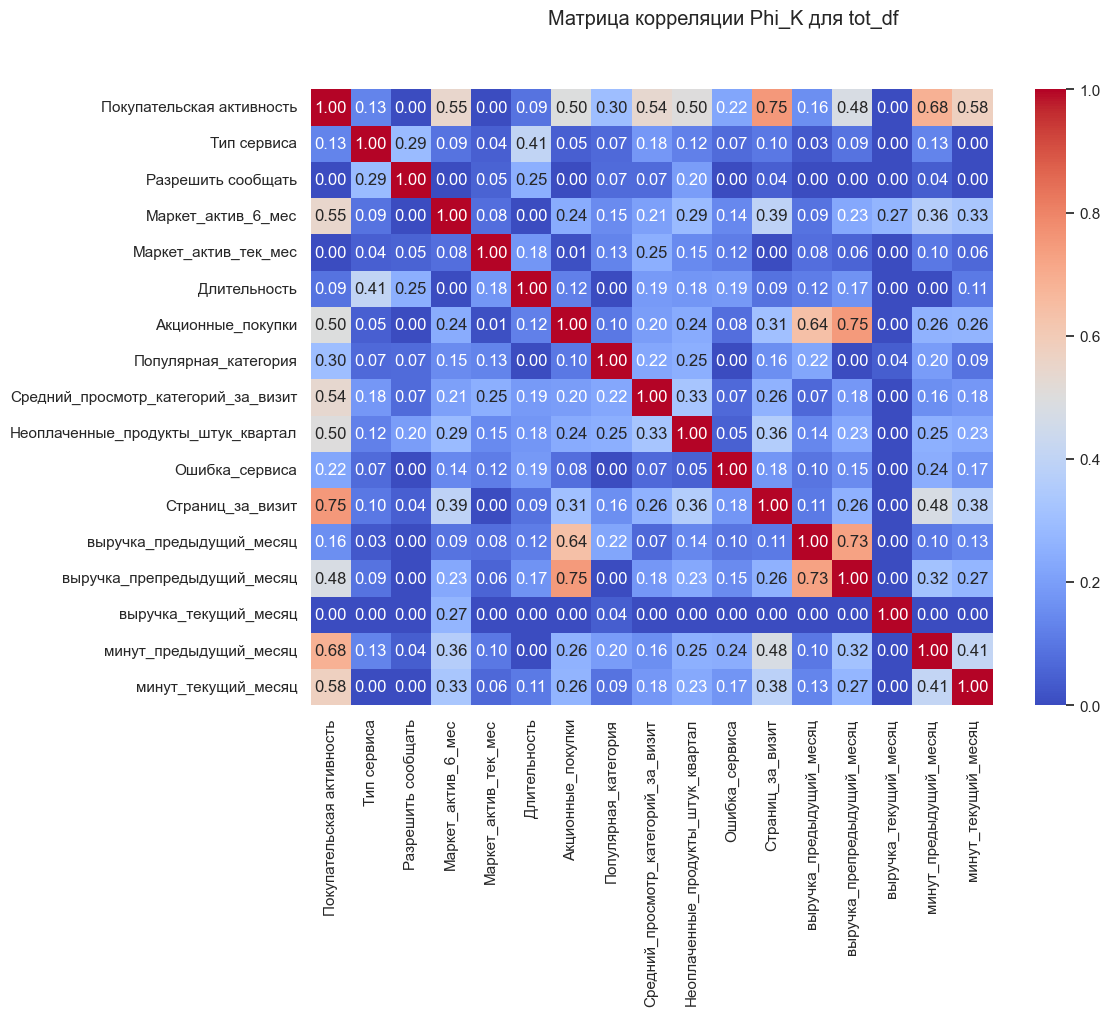

In [50]:
plt.suptitle('Матрица корреляции Phi_K для tot_df')
sns.heatmap(tot_df.drop('id',axis=1).phik_matrix(num_col), annot=True, fmt='.2f', cmap="coolwarm");

С целевым признаком коррелируют признаки:
* Страниц_за_визит (коэффициент 0.75);
* минут_за_предыдущий_месяц (коэффициент 0.68);
* минут_текущий_месяц (коэффициент 0.58);
* маркет_актив_6_мес (коэффициент 0.55);
* Средний_просмотр_категорий_за_визит (коэффициент 0.54)
<br> Также наблюдается корреляция между признком Акционные_покупки и выручкой за препредыдущий (0.75) и предыдущий месяцы (0.64). Но знчения менее 0.9, что служит порогом для вывода о мультиколлинеарности.


# 6. Создание пайплайнов моделей ML

Поскольку требуестя предсказать изменение покупательской активности, которая согласно данным таблицы 'market_file' либо снизится, либо останентся на прежнем уровне, то это задача бинарной классификации.
<br> Для автоматизации создания и выбора самой лучшей по её гиперпараметрам модели классификации из ряда моделей - логистической регррессии, kNN, деревьев решений и классификатора методом опорных векторов (SVC), создается пайплайн.  

Кодирую целевой признак:

Признаки для кодирования OneHotEncoder:

In [51]:
ohe_col = ['Разрешить сообщать', 'Популярная_категория']

Пайплайн для кодирования категориальных признаков OneHotEncoder:

In [52]:
ohe_pipe = Pipeline(
    [
      (
       'sim_imp_ohe', #для тренировки
       SimpleImputer(missing_values=np.nan, strategy='most_frequent')
      ),
      (
       'ohe',
       OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
      )
    ]
)

Признаки, кодируемые OrdinalEncoder:

In [53]:
ord_col = ['Тип сервиса']

Пайплайн для кодирования OrdinalEncoder:

In [54]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Собираю пайплайн для обработки данных:

In [55]:
data_preproc = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col),
    ],
    remainder='passthrough'
)

Итоговый пайплан для обучения модели:

In [56]:
fin_pipe = Pipeline(
    [
        ('preproc', data_preproc),
        ('models', LogisticRegression())
    ]
)

Для перебора гиперпарамертов пайплайна как для масштабирования данных, так и гиперпараметров модели классификации создаю список из словарей:

In [57]:
param_distr = [
    {
        'models': [LogisticRegression(
            random_state = RANDOM_STATE,
            penalty='l1',
            solver = 'saga'
            )],
        'models__C': range(1, 5),
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 50),
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(
            random_state = RANDOM_STATE,
            kernel='rbf'
            )],
        'models__gamma': [0.01, 0.1, 1, 5, 10],
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    }
]

Использую RandomizedSearchCV для подбора самой эффективной модели. В качестве метрики использую ROC_AUC, поскольку она обощенно отражает качество модели вне зависимости от величины порога классификации.

In [58]:
rand_srch = RandomizedSearchCV(
    fin_pipe,
    param_distr,
    cv = 5,
    scoring='roc_auc',
    random_state = RANDOM_STATE,
    n_jobs=-1,
)

Готовлю данные для обучения:

In [59]:
X = tot_df.drop(['id','Покупательская активность'], axis=1)
y = tot_df['Покупательская активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state=RANDOM_STATE,
    stratify = y
)
y_test_pure = y_test
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

Кодирую целевой признак:

In [60]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Визуализирую как закодирован целевой признак:

In [61]:
pd.DataFrame(zip(y_test_pure, y_test), columns=['до кодирования', 'после кодирования']).head()

Комментарий: здесь умышленно воспользовался LabelEncoder для трненировки, а поскольку он кодирует признаки исходя из литеральной последовательности, от по сути негативный для бизнеса признак "Снизилась" закодирован позитивно в 1.

Обучаю модель не тренировочных данных:

In [62]:
data_preproc.fit(X_train)

In [63]:
rand_srch.fit(X_train, y_train)

Вывожу параметры моделей и результаты расчета средней метрики в таблицу:

In [64]:
result = pd.DataFrame(rand_srch.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

Метрика лучшей модели на тестовых данных:

In [70]:
y_test_pred = rand_srch.predict_proba(X_test)
print(f'ROC AUC для лучшей модели на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1]):0.2f}')

Метрика на обучающей выборке упала с 0,91 до 0,89. Это говорит о том, что в обучающем сете модель подстроилась под тестовые данные. Но разница не очень большая.

Достаю лучшуюю модель:

In [66]:
train_features = rand_srch.best_estimator_[0]
features = train_features.get_feature_names_out() #- в текущей версии 0.24 этоо не работает
#features = train_features.transformers_[0][1]['ohe'].get_feature_names().tolist()
#features.extend(num_col)
best_model = rand_srch.best_estimator_[1]

In [67]:
best_model

In [68]:
X_train_p = pd.DataFrame(
    data=train_features.transform(X_train),
    columns=features
    )
X_test_p = pd.DataFrame(
    data=train_features.transform(X_test),
    columns=features
    )

In [69]:
X_test_p.head()

# 7. Анализ важности признаков

Анализ важности признаков для лучшей модели производится методом SHAP.

Поскольку лучшей оказалась модель kNN, то вывожу shap для неё. Для сохранения времени делаю вывод на тестовой выборке из-за её меньшего размера.

In [69]:
shap_explainer = shap.KernelExplainer(best_model.predict_proba, X_train_p)
shap_values = shap_explainer(X_test_p)

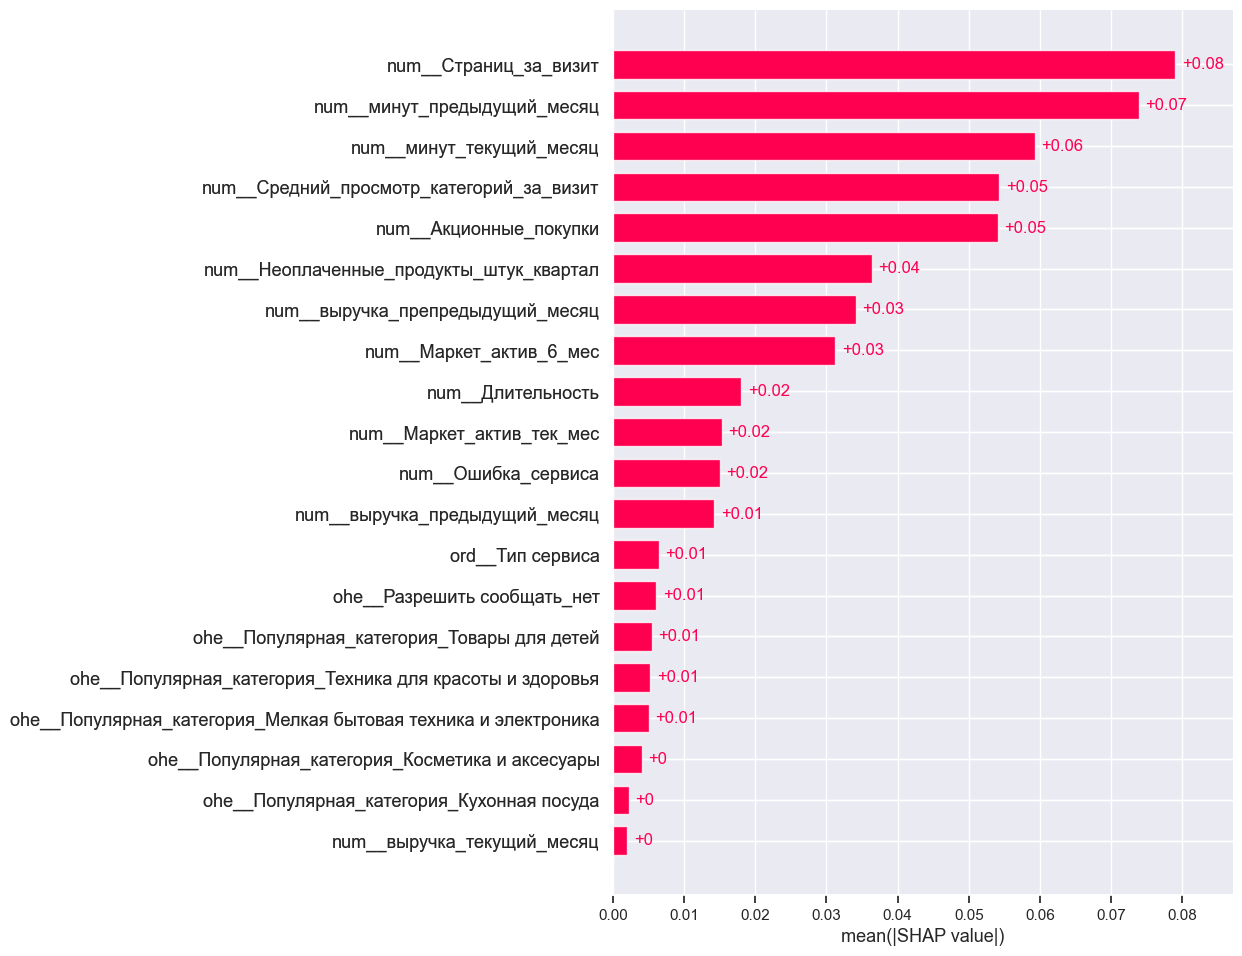

In [70]:
shap.plots.bar(shap_values[:,:,1], max_display=20)

На целевой признак сильнее всего влияют:
* Страниц_за_визит
* минут_предыдущий_месяц;
* минут_текущий_месяц;
* средний_просмотр_категорий_за_визит
<br> Первые три признака были выделены из матрицы Phik на этапе анализа корреляции как имевшие самые высокие коэффициенты корреляции. А вот признак "Маркет_актив_6_мес" не вошел в пятёрку оказывающих наибольшее влияние.
<br> как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?
<br> Если покупатель стал меньше времени проводить на сайте, ему можно выслать дополнительную информацию о просмотренных товарах, а также жобавить информацию об акциях на похожие товары. Диаграмма показывет, что очень много наблюдений с классом "прежняя" активность для признака акционные покупки.   

# 8. Сегментация покупателей


Для анализа влияния величины прзнака на предсказание модели вывожу beeswarm plot для значения целевого признака "Снизилась" (идет со значением "1" согласно кодировке)

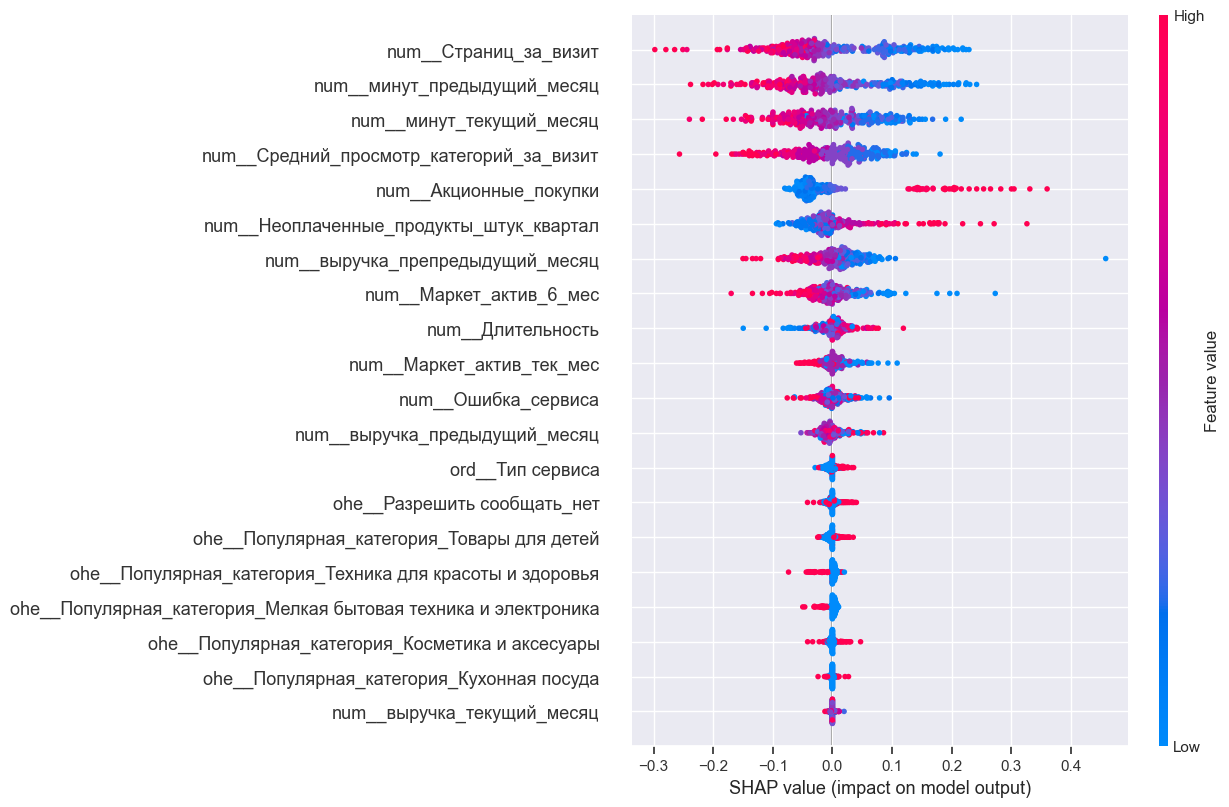

In [71]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

8.1 Сегментация покупателей

Провожу сегментацию покупателей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.



Выделяю покупателей с высокой прибыльностью:

In [72]:
segment = money_df[money_df['Прибыль'] > 5000].id

In [73]:
segment_data = tot_df.loc[segment.index]
segment_data = segment_data[segment_data['Покупательская активность'] == "Снизилась"]

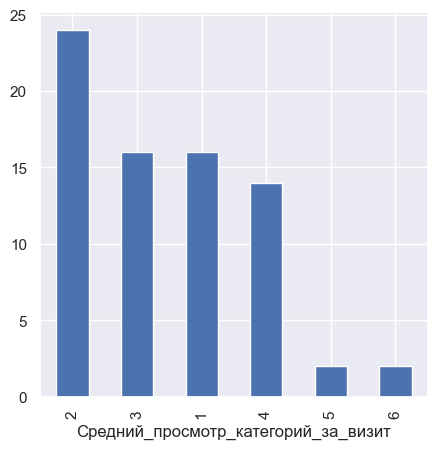

In [79]:
segment_data['Средний_просмотр_категорий_за_визит'].value_counts().plot(kind='bar');

Получается что большая часть покупателей смотрит от одной до трех категорий за визит. А согласно beeswarm plot рост числа категорий позволит сохранить покупательскую активность. Есть смысл предлагать покупателям с небольшим количесвтом просмотров категорий несколько часто просматриваемых категорий для привлечения внимания к их товарам.

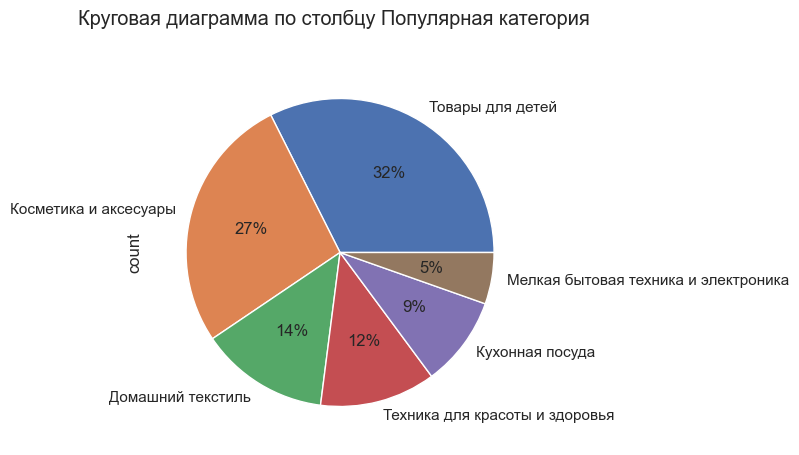

In [75]:
plt.rcParams['figure.figsize'] = [5, 5]
segment_data['Популярная_категория'].value_counts().plot(kind='pie', autopct='%.0f%%');
title = 'Круговая диаграмма по столбцу Популярная категория'
plt.suptitle(title)
plt.show()

Для покупателей, приобретавших технику и электронику ожидать активности по приобретению новых товаров не стоит, но если им предложить аксессуары для уже купленных товаров это их привлечет.
<br> Для покупателей кухонной посуды и домашнего текстиля можно предложить средства для ухода за ними (для их мойки/чистки)

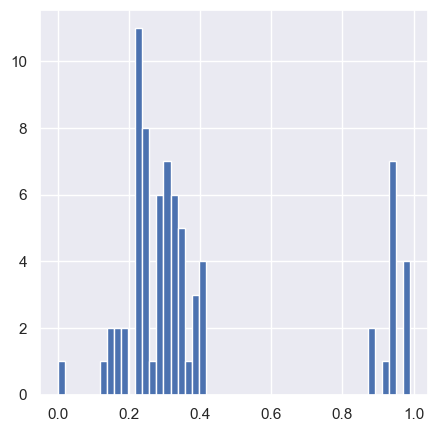

In [76]:
segment_data['Акционные_покупки'].hist(bins=50);

Нет покупателей, у которых половина товаров была бы по акции. Но доля покупателей с высоким процентом акционных покупок не такая большая. Для всей выборки она составляла 12,7%. Больше акций, как показал beeswarm plot приведет к тому, что покупательская активность снизится. И это логично - пройдет быстрое насыщение товарами, которые покупателю нужны. Акции можно провести на залежавшиеся в корзине товары покупателей для кратковременного стимулирования их активности. 

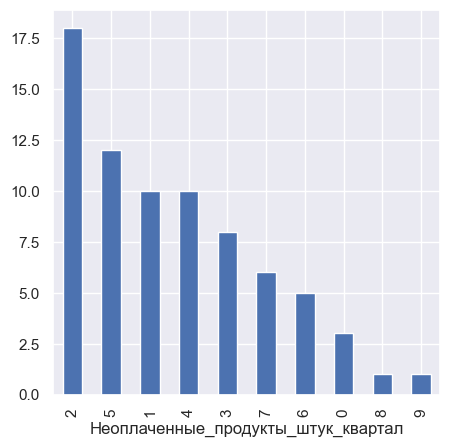

In [80]:
segment_data['Неоплаченные_продукты_штук_квартал'].value_counts().plot(kind='bar');

Рост числа неоплаченных продуктов в корзине согласно beeswarm plot показывает что покупательская активнось снижается. Возможно покупатель ждет акции. Следует отправить напоминание покупателю о том, что "товар залежался в корзине и его могут купить", чтобы повысить покупательскую активность.

Таким образом для сегмента покупателей, приносящих наибольшую прибыль и имеющих высокую вероятность снижения покупательской активности рекомендуется:
1. повысить просмотр категорий, которыми покупатель не интереосвался для привлечения его внимания путем рассылки уведомлений;
1. выслать рекомендацию покупки акксесуаров для приобретенной техники и электроники, если приобреталась посуда или текстиль - средства по уходу, чистке;
2. увеличение акционных товаров согласно расчету SHAP приведет к снижению активности;
3. если у клиента растет число неоплаченных покупок, то можно выслать ему напоминание о "залежавшемся в корзине товаре".

# 9. Общий вывод

По данным о продуктовом, финансовом и поведении на сайте, а также коммуникациях с клиентом за период времени до 3х месяцов была создана модель, предсказывающая вероятность снижения покупательной активности в следующие три месяца.
<br> Прелварительно данные были предобработаны и исследованы. Был проведен анализ коррелиции и выделены ряд признаков, кореллирующие с целевым. SHAP налаиз всех признаков подтвердил значимость большей части этих признаков.
<br>
<br> Сама модель была получена путем отбора лучшей из четырех типов рассматриваемых моделей и ряда их гиперпараметров. Лучшей оказалась модель kNN  с числом соседей 6.
<br>
<br> Был рассмтрен сегмент покупателей с высокой прибыльностью но со сниженной покупательной активность. По результатам анализа значений SHAP для признаков модели и данных об этих покупатлях даны следующие рекомендации для повышения их покупательной активности:
1. повысить просмотр категорий, которыми покупатель не интереосвался для привлечения его внимания путем рассылки уведомлений;
1. выслать рекомендацию покупки акксесуаров для приобретенной техники и электроники, если приобреталась посуда или текстиль - средства по уходу, чистке;
2. увеличение купленных клиентом акционных товаров, согласно расчету SHAP, приведет к снижению активности, поэтому локальные акции например на залежавшиеся в корзине неоплаченные товары могут простимулировать активность, но много их быть не должно;
3. если у клиента растет число неоплаченных покупок, то можно выслать ему напоминание о "залежавшемся в корзине товаре".